In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio

In [ ]:
data = np.load(f"lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images: [10, 200, 200, 3]
images_val = data["images_val"] / 255.0

# Cameras for the validation images:
# (camera-to-world transformation matrix): [10, 4, 4]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering:
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float

# Generate the intrinsic matrix
H, W, _ = images_train[0].shape
K = np.array([[float(focal), 0.0, W / 2.0],
              [0.0, float(focal), H / 2.0],
              [0.0, 0.0, 1.0]], dtype=np.float32)

In [ ]:
# Transform a point from camera space to world space (x_w)
# The shape of c2w is (B, 4, 4)
# The shape of x_c is (B, 3)
# The shape of x_w is (B, 3)
def transform(c2w, x_c):
    # Extract rotation and translation
    R = c2w[:, :3, :3] # (B, 3, 3)
    t = c2w[:, :3, 3] # (B, 3)

    # Apply transform: x_w = R @ x_c + t
    # Squeezed x_c (B, 3, 1) which allows for matmul and
    # then squeeze to get rid of the added dim
    x_w = (R @ x_c.unsqueeze(-1)).squeeze(-1) + t
    return x_w

# Transform a pixel to a point in camera space (x_c)
# The shape of K is (3, 3)
# The shape of uv is (B, 2)
# The shape of s is (B, 1)
# The shape of x_c is (B, 3)
def pixel_to_camera(K, uv, s):
  
  # Build homogeneous pixel coordinates (u, v, 1)
  ones = torch.ones_like(s)   # (B, 1)
  uv_h = torch.cat([uv, ones], dim=-1) # (B, 3)

  # Multiply by inverse intrinsics and scale by depth
  K_inv = torch.linalg.inv(K) # (3, 3)
  x_c = (uv_h @ K_inv.T) * s # (B, 3) @ (3, 3)

  return x_c

# Transforms a pixel to ray (ray_o, ray_d)
# The shape of K is (3, 3)
# The shape of c2w is (B, 4, 4)
# The shape of uv is (B, 2)
# The shape of ray_o is (B, 3)
# The shape of ray_d is (B, 3)
def pixel_to_ray(K, c2w, uv):
  ray_o = c2w[:, :3, 3] # (B, 3)

  # Convert the pixels to world coordinates with ray depth of 1
  s = torch.ones((uv.shape[0], 1), device=uv.device, dtype=uv.dtype) # (B, 1)
  x_c = pixel_to_camera(K, uv, s) # (B, 3)
  x_w = transform(c2w, x_c) # (B, 3)

  # Calculate the ray direction
  diff = x_w - ray_o
  ray_d = diff / torch.linalg.norm(diff, dim=-1, keepdim=True)  # (B, 3)

  return ray_o, ray_d

In [ ]:
class RaysData():
  def __init__(self, images, K, c2ws, numpy=False, device="cpu"):
    """
    images: (B, H, W, 3) numpy array or torch tensor
    K: (3, 3) intrinsic matrix (assume same for all images)
    c2ws: (B, 4, 4) camera-to-world poses
    """
    self.B, self.H, self.W, _ = images.shape
    self.images = torch.tensor(images, dtype=torch.float32, device=device)                # (B, H, W, 3)
    self.K = torch.tensor(K, dtype=torch.float32, device=device)                          # (3, 3)
    self.c2ws = torch.tensor(c2ws, dtype=torch.float32, device=device)                    # (B, 4, 4)

    self.pixels = torch.tensor(images.reshape(-1, 3), dtype=torch.float32, device=device) # (B * H * W, 3)
    self.uvs = build_pixel_grid(self.H, self.W).to(device)                                # (H * W, 2)
    self.rays_o, self.rays_d = self.compute_all_rays()                                    # (B * H * W, 3)

    self.numpy = numpy;
    if numpy:
      self.images = self.images.cpu().numpy()
      self.K = self.K.cpu().numpy()
      self.c2ws = self.c2ws.cpu().numpy()
      self.pixels = self.pixels.cpu().numpy()
      self.uvs = self.uvs.cpu().numpy()
      self.rays_o = self.rays_o.cpu().numpy()
      self.rays_d = self.rays_d.cpu().numpy()

  # Computes all the rays for all the images
  # ray is shape (B * H * W, 3)
  def compute_all_rays(self):
      # (H * W, 2) -> (B, H * W, 2) -> (B * H * W, 2)
      uvs = self.uvs[None, :, :].expand(self.B, -1, -1).reshape(-1, 2)

      # (B, 4, 4) -> (B, H * W, 4, 4) -> (B * H * W, 4, 4)
      c2ws = self.c2ws[:, None, :, :].expand(self.B, self.H * self.W, 4, 4).reshape(-1, 4, 4)

      ray_o, ray_d = pixel_to_ray(self.K, c2ws, uvs)

      return ray_o, ray_d

  # rays are shape (B, 3)
  # pixels are shape (B, 3)
  def sample_rays(self, N):
    BHW, _ = self.rays_o.shape

    # Generate a random permutation of BHW values and grab the first N
    idx = torch.randperm(BHW)[:N]
    return self.rays_o[idx], self.rays_d[idx], self.pixels[idx]

In [ ]:
# Returns uv grid of shape (H * W, 2) offset by 0.5
def build_pixel_grid(H, W):
  u = torch.arange(W) # (W, )
  v = torch.arange(H) # (H, )

  vv, uu = torch.meshgrid(v, u, indexing="ij")  # both (H, W)

  # (H, W, 2) -> (H * W, 2)
  uv = torch.stack([uu, vv], dim=-1).reshape(-1, 2) + 0.5
  return uv

# Sample points from N rays from all of the images
# s_x is shape (N, n_samples, 3)
def sample_along_rays(rays_o, rays_d, perturb=True, near=2.0, far=6.0, n_samples=32):
  N = rays_o.shape[0]
  dt = (far - near) / (n_samples - 1)
  is_torch = isinstance(rays_o, torch.Tensor)

  if is_torch:
    device = rays_o.device

    # Uniformly sample along each ray with small perturbation
    t_vals = torch.linspace(near, far, n_samples, device=device)  # (n_samples, )

    # t_vals (n_samples, ) -> (1, n_samples) -> (N, n_samples)
    if perturb:
      t_vals = t_vals[None, :] + (torch.rand(N, n_samples, device=device) - 0.5) * dt
    else:
        t_vals = t_vals[None, :].expand(N, -1)

  else:
    t_vals = np.linspace(near, far, n_samples, dtype=np.float32)  # (n_samples, )

    # t_vals (n_samples, ) -> (1, n_samples) -> (N, n_samples)
    if perturb:
        t_vals = t_vals[None, :] + (np.random.rand(N, n_samples) - 0.5).astype(np.float32) * dt
    else:
        t_vals = t_vals[None, :].repeat(N, axis=0)

  # Compute 3D points along the ray
  # ray (N, 3) -> (N, 1, 3) -> (N, n_samples, 3)
  # t_vals (N, n_samples) -> (N, n_samples, 1) -> (N, n_samples, 3)
  s_x = rays_o[:, None, :] + rays_d[:, None, :] * t_vals[:, :, None]   # (N, n_samples, 3)

  return s_x

In [ ]:
%pip install viser
import viser, time  # pip install viser
import numpy as np

# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train, numpy=True)
rays_o, rays_d, pixels = dataset.sample_rays(100) # Should expect (B, 3)
points = sample_along_rays(rays_o, rays_d, perturb=True)
H, W = images_train.shape[1:3]
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
    server.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K[0, 0]),
        aspect=W / H,
        scale=0.15,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image
    )
for i, (o, d) in enumerate(zip(rays_o, rays_d)):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.02,
)

while True:
    time.sleep(0.1)  # Wait to allow visualization to run

In [ ]:
# Visualize Cameras, Rays and Samples
%pip install viser
import viser, time
import numpy as np

# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train, numpy=True)

# This will check that your uvs aren't flipped
uvs_start = 0
uvs_end = 40_000
sample_uvs = dataset.uvs[uvs_start:uvs_end] # These are integer coordinates of widths / heights (xy not yx) of all the pixels in an image
sample_uvs = sample_uvs.astype(np.int32)

# uvs are array of xy coordinates, so we need to index into the 0th image tensor with [0, height, width], so we need to index with uv[:,1] and then uv[:,0]
assert np.allclose(images_train[0, sample_uvs[:,1], sample_uvs[:,0]], dataset.pixels[uvs_start:uvs_end])

# # Uncoment this to display random rays from the first image
# indices = np.random.randint(low=0, high=40_000, size=100)

# # Uncomment this to display random rays from the top left corner of the image
# indices_x = np.random.randint(low=100, high=200, size=100)
# indices_y = np.random.randint(low=0, high=100, size=100)
# indices = indices_x + (indices_y * 200)

data = {"rays_o": dataset.rays_o[indices], "rays_d": dataset.rays_d[indices]}
points = sample_along_rays(data["rays_o"], data["rays_d"], perturb=True)

# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
  server.add_camera_frustum(
    f"/cameras/{i}",
    fov=2 * np.arctan2(H / 2, K_c[0, 0]),
    aspect=W / H,
    scale=0.15,
    wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
    position=c2w[:3, 3],
    image=image
  )
for i, (o, d) in enumerate(zip(data["rays_o"], data["rays_d"])):
  positions = np.stack((o, o + d * 6.0))
  server.add_spline_catmull_rom(
      f"/rays/{i}", positions=positions,
  )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.03,
)

while True:
    time.sleep(0.1)  # Wait to allow visualization to run

In [6]:
# Returns a function parameterized by L which converts p, a 3D point, to a L * 6 + 3 dim vector
def PE(L):
  # Create frequency bands
  device = "cuda" if torch.cuda.is_available() else "cpu"
  freq_bands = (2.0 ** torch.arange(L, device=device)) * torch.pi  # [L]

  def return_func(p):
    b, d = p.shape

    # p has shape [b, 3], add a new axis -> [b, 3, 1]
    # freq_bands is [L]
    # Broadcast multiplication -> [b, 3, L]
    p_expanded = p[..., None] * freq_bands

    # Compute sin and cos encodings
    sin_enc = torch.sin(p_expanded)  # [b, 3, L]
    cos_enc = torch.cos(p_expanded)  # [b, 3, L]

    # Flatten the frequency dimension into the coordinate dimension:
    # [b, 3, L] -> [b, 3 * L]
    sin_flat = sin_enc.reshape(b, -1)
    cos_flat = cos_enc.reshape(b, -1)

    # p has shape [b, 3]
    # flat has shape [b, 3 * L]
    # Concatenate all of the values across the last dimension
    pe = torch.cat([p, sin_flat, cos_flat], dim=-1)  # [b, 3 + 6L]
    return pe

  return return_func

class NERF_3D(nn.Module):
  def __init__(self, L_x = 10, L_dir = 4):
    super().__init__()

    in_dim_x = 6 * L_x + 3
    in_dim_dir = 6 * L_dir + 3

    self.PE_x = PE(L_x)
    self.PE_dir = PE(L_dir)

    # Main MLP
    self.layer1 = nn.Linear(in_dim_x, 256)
    self.layer2 = nn.Linear(256, 256)
    self.layer3 = nn.Linear(256, 256)
    self.layer4 = nn.Linear(256, 256)

    # Account for the concatenation (input dim is 256 + in_dim_x)
    self.layer5 = nn.Linear(256 + in_dim_x, 256)
    self.layer6 = nn.Linear(256, 256)
    self.layer7 = nn.Linear(256, 256)
    self.layer8 = nn.Linear(256, 256)

    # To calculate the sigma values
    self.sigma_layer_1 = nn.Linear(256, 1)

    # To calculate the rgb values
    self.rgb_layer_1 = nn.Linear(256, 256)
    self.rgb_layer_2 = nn.Linear(256 + in_dim_dir, 128)
    self.rgb_layer_3 = nn.Linear(128, 3)

  # x is shape (B, 3)
  # ray_d is shape (B, 3)
  def forward(self, x, ray_d):
    # Get the positional encodings of both values
    x_enc = self.PE_x(x)
    ray_d_enc = self.PE_dir(ray_d)

    # Go throught the main section before concatenation
    h = F.relu(self.layer1(x_enc))
    h = F.relu(self.layer2(h))
    h = F.relu(self.layer3(h))
    h = F.relu(self.layer4(h))

    # Concatenate the input x to the current output
    h = torch.cat([h, x_enc], dim=-1)
    h = F.relu(self.layer5(h))
    h = F.relu(self.layer6(h))
    h = F.relu(self.layer7(h))
    h = F.relu(self.layer8(h))

    # Get the sigmas
    sigmas = F.softplus(self.sigma_layer_1(h))

    # Get the rgb value
    rgbs = self.rgb_layer_1(h)
    rgbs = torch.cat([rgbs, ray_d_enc], dim=-1)
    rgbs = F.relu(self.rgb_layer_2(rgbs))
    rgbs = torch.sigmoid(self.rgb_layer_3(rgbs))

    return rgbs, sigmas

In [7]:
# sigmas is shape (B, N, 1)
# rgbs is shape (B, N, 3)
# step_size is scalar
def volrend(sigmas, rgbs, step_size):
    d_sigmas = -sigmas * step_size

    # Calculate Ti by doing the cumulative sum and then adding a zero
    # at the start and chopping off the end before exponentiating
    Ti = (torch.cumsum(d_sigmas, dim=1))
    zero = torch.zeros_like(Ti[:, 0:1, :])
    T1 = torch.cat([zero, Ti[:, :-1, :]], dim=1)
    Ti = torch.exp(T1)

    # Accumulate color
    rgb_final = torch.sum(Ti * (1 - torch.exp(d_sigmas)) * rgbs, dim=1)

    return rgb_final

In [8]:
# Training loop
def train_loop(model, optimizer, loss_fn, device, epochs, batch_size, near, far, n_samples, images_val, c2ws_val, c2ws_test, output_folder):

  # Set the model into training mode
  model.train()
  training_psnr_values = []
  validating_psnr_values = []
  loss_values = []

  step_size = (far - near) / (n_samples - 1)

  test_view = c2ws_test[0, :, :]

  for i in range(epochs):

    optimizer.zero_grad()

    # Sample rays, pixels, and 3d points
    rays_o, rays_d, actual_colors = dataset.sample_rays(batch_size) # (B, 3)
    points = sample_along_rays(rays_o, rays_d, perturb=True, near=near, far=far, n_samples=n_samples) # (B, n_samples, 3)

    # Reshape points and expand rays_d so they're both flattened and of shape (B * n_samples, 3)
    points = points.reshape(-1, 3) # (B, n_samples, 3) ->(B * n_samples, 3)
    rays_d = rays_d.repeat_interleave(n_samples, dim=0)  # (B, 3) -> (B * n_samples, 3)

    # Model takes in 3d points and ray directions and outputs a rendered color
    rgbs, sigmas = model(points, rays_d)

    # Reshape the outputs of the model to be (B, n_samples, dim)
    # since that's what volrend expects
    rgbs = rgbs.reshape(batch_size, n_samples, 3)
    sigmas = sigmas.reshape(batch_size, n_samples, 1)
    predicted_colors = volrend(sigmas, rgbs, step_size) # (B, 3)

    # Compare between the predicted color and the
    loss = loss_fn(predicted_colors, actual_colors)
    loss.backward()
    optimizer.step()

    # Calculate the psnr value and save it
    training_psnr = psnr_fn(loss).item()
    training_psnr_values.append(training_psnr)

    # Save the loss values too
    loss_values.append(loss.item())

    if i % 100 == 0:
      print(f"Epoch {i}, Training Loss: {loss.item():.6f}, PSNR: {training_psnr:.2f} dB")

    # Only validate every 1000 epochs
    if i % 1000 == 0 or i == epochs - 1:
      # validating_psnr = validate(images_val, c2ws_val, dataset.K, dataset.H, dataset.W, model, near=near, far=far, n_samples=n_samples, uvs=dataset.uvs, loss_fn=loss_fn)
      # validating_psnr_values.append(validating_psnr)
      # print(f"Epoch {i}, Validating PSNR: {validating_psnr:.2f} dB")

      # Generate the test view and save it
      test_image = generate_view(test_view, dataset.K, dataset.H, dataset.W, model, near=near, far=far, n_samples=n_samples, uvs=dataset.uvs)
      test_image = (test_image.clamp(0, 1) * 255).to(torch.uint8).cpu().numpy()
      imageio.imwrite(f"test_view_{i}.jpg", test_image)

  plot_and_save(training_psnr_values, output_folder, "./psnr_training.jpg", "PSNR (dB) over epochs", "Epoch", "PSNR (dB)")
  plot_and_save(validating_psnr_values, output_folder, "./psnr_validating.jpg", "PSNR (dB) over epochs", "Epoch (x100)", "PSNR (dB)")
  plot_and_save(loss_values, output_folder, "./training_loss.jpg", "Loss over epochs", "Epoch", "Loss")

def validate(images_val, c2ws_val, K, H, W, model, near, far, n_samples, uvs, loss_fn):
  psnrs = []
  for i in range(len(images_val)):
      # Render this view
      rendered_np = generate_view(c2ws_val[i], K, H, W, model, near, far, n_samples, uvs)
      val_loss = loss_fn(rendered_np, images_val[i])
      psnr = psnr_fn(val_loss)
      psnrs.append(psnr.item())

  return sum(psnrs) / len(psnrs)

def generate_view(c2ws_val, K, H, W, model, near, far, n_samples, uvs):
  # Set model to evaluation mode
  model.eval()

  # Calculate step size for volume rendering
  step_size = (far - near) / (n_samples - 1)

  # Expand c2w to match the number of rays (H * W)
  # (4, 4) -> (1, 4, 4) -> (H * W, 4, 4)
  c2ws_val = c2ws_val[None, ...].expand(H * W, 4, 4)

  # (H * W, 3)
  rays_o, rays_d = pixel_to_ray(K, c2ws_val, uvs)

  # Use torch.no_grad() to disable gradient computation for speed/memory
  with torch.no_grad():

    # Sample points along the rays and flatten
    # (H * W, n_samples, 3) -> (H * W * n_samples, 3)
    points = sample_along_rays(rays_o, rays_d, perturb=False, near=near, far=far, n_samples=n_samples)
    points = points.reshape(-1, 3)

    # (H * W, 3) -> (H * W * n_samples, 3)
    rays_d = rays_d.repeat_interleave(n_samples, dim=0)

    # Get model outputs
    rgbs, sigmas = model(points, rays_d)

    # Reshape for volume rendering
    rgbs = rgbs.reshape(H * W, n_samples, 3)
    sigmas = sigmas.reshape(H * W, n_samples, 1)

    # Render the colors (H * W, 3) -> (H, W, 3)
    predicted_colors = volrend(sigmas, rgbs, step_size)

    predicted_colors = predicted_colors.reshape(H, W, 3)

    # Put the model back into training mode
    model.train()

    return predicted_colors

def psnr_fn(mse_loss):
    return -10.0 * torch.log10(mse_loss)

def plot_and_save(values, folder, filename, title, xlabel, ylabel):
  plt.figure(figsize=(10, 5))
  plt.plot(values)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid(True)

  # Make sure to save before showing since showing clears the canvas
  plt.savefig(folder + filename, bbox_inches="tight", dpi=300)
  plt.show()

Epoch 0, Training Loss: 0.166423, PSNR: 7.79 dB
Epoch 0, Validating PSNR: 7.84 dB
Epoch 100, Training Loss: 0.047572, PSNR: 13.23 dB
Epoch 100, Validating PSNR: 14.12 dB
Epoch 200, Training Loss: 0.016515, PSNR: 17.82 dB
Epoch 200, Validating PSNR: 18.19 dB
Epoch 300, Training Loss: 0.010275, PSNR: 19.88 dB
Epoch 300, Validating PSNR: 20.20 dB
Epoch 400, Training Loss: 0.009161, PSNR: 20.38 dB
Epoch 400, Validating PSNR: 21.06 dB
Epoch 500, Training Loss: 0.007410, PSNR: 21.30 dB
Epoch 500, Validating PSNR: 21.86 dB
Epoch 600, Training Loss: 0.007393, PSNR: 21.31 dB
Epoch 600, Validating PSNR: 22.48 dB
Epoch 700, Training Loss: 0.005934, PSNR: 22.27 dB
Epoch 700, Validating PSNR: 22.99 dB
Epoch 800, Training Loss: 0.005126, PSNR: 22.90 dB
Epoch 800, Validating PSNR: 23.50 dB
Epoch 900, Training Loss: 0.005059, PSNR: 22.96 dB
Epoch 900, Validating PSNR: 23.74 dB
Epoch 999, Training Loss: 0.004940, PSNR: 23.06 dB
Epoch 999, Validating PSNR: 24.03 dB


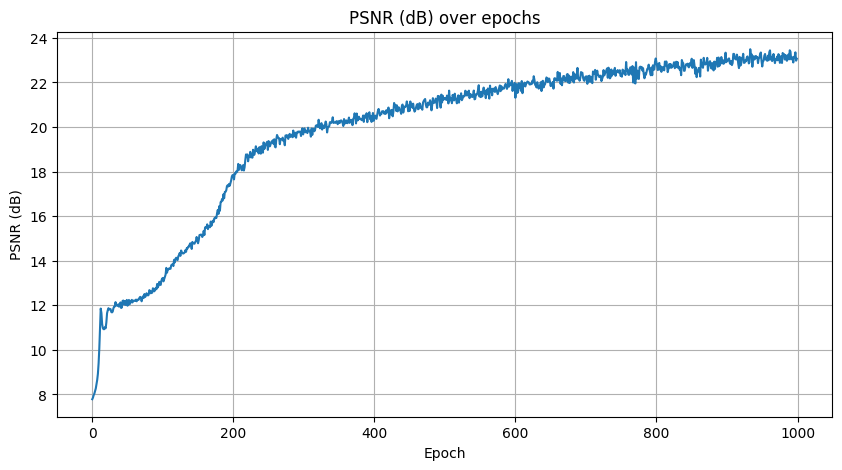

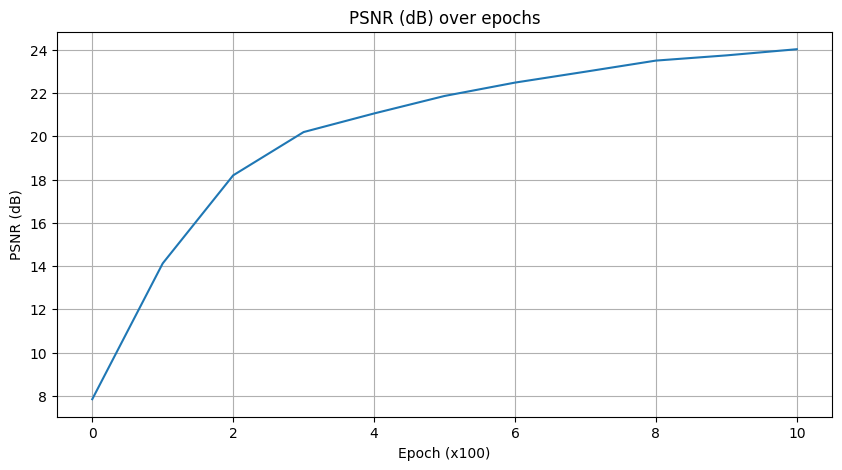

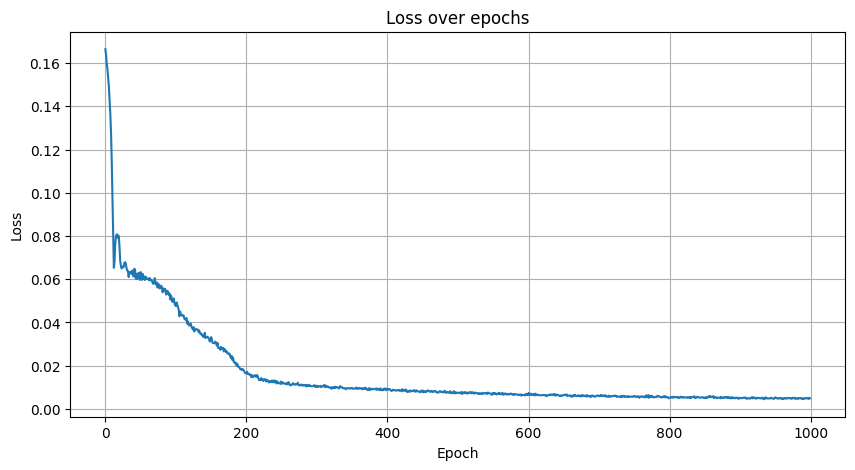

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 5e-4
batch_size = 10000
epochs = 1000
output_folder = "./"
near = 2.0
far = 6.0
n_samples = 64

# Move validation images and c2ws to the device
images_val_t = torch.tensor(images_val, device=device, dtype=torch.float32)
c2ws_val_t = torch.tensor(c2ws_val, device=device, dtype=torch.float32)
c2ws_test_t = torch.tensor(c2ws_test, device=device, dtype=torch.float32)

# Create the model and move it to the GPU
model = NERF_3D().to(device)

# Load the dataset and move it onto the gpu
dataset = RaysData(images_train, K, c2ws_train, device=device)

# Create the loss function and the optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Pass the GPU data to the train_loop
train_loop(model, optimizer, loss_fn, device, epochs, batch_size, near, far, n_samples, images_val_t, c2ws_val_t, c2ws_test_t, output_folder)

In [9]:
def generate_frames(extrinsics, dataset, model, near, far, n_samples):
    frames = []

    for extrinsic in extrinsics:
      # Generate view for this camera pose
      frame = generate_view(extrinsic, dataset.K, dataset.H, dataset.W, model, near, far, n_samples, uvs=dataset.uvs)
      frame = (frame.clamp(0, 1) * 255).to(torch.uint8).cpu().numpy() # Convert the frame to a numpy array on the cpu
      frame = pad_to_16(frame)
      frames.append(frame)

    return frames

#imageio expectes videos to have dimensions divisible by 16, this pads to the frame to a dimension divisible by 16
def pad_to_16(img):
    h, w = img.shape[:2]
    H = (h + 15) // 16 * 16
    W = (w + 15) // 16 * 16

    padded = np.zeros((H, W, 3), dtype=img.dtype)
    padded[:h, :w] = img
    return padded

def save_video(frames, output_path):
    imageio.mimsave(output_path, frames, fps=15, quality=5)

In [ ]:
# Generate circling video of the lego
lego_frames = generate_frames(c2ws_test_t, dataset, model, near, far, n_samples)
save_video(lego_frames, "./lego_test_views.mp4")

In [10]:
data = np.load("my_data.npz")

images_train = data["images_train"] / 255.0

# Cameras for the training images
c2ws_train = data["c2ws_train"]

# Validation images
images_val = data["images_val"] / 255.0

# Cameras for the validation images
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float

# Generate the intrinsic matrix
H, W, _ = images_train[0].shape
K = np.array([[float(focal), 0.0, W / 2.0],
                  [0.0, float(focal), H / 2.0],
                  [0.0, 0.0, 1.0]], dtype=np.float32)

Epoch 0, Training Loss: 0.187082, PSNR: 7.28 dB
Epoch 100, Training Loss: 0.057282, PSNR: 12.42 dB
Epoch 200, Training Loss: 0.038603, PSNR: 14.13 dB
Epoch 300, Training Loss: 0.033669, PSNR: 14.73 dB
Epoch 400, Training Loss: 0.032311, PSNR: 14.91 dB
Epoch 500, Training Loss: 0.030441, PSNR: 15.17 dB
Epoch 600, Training Loss: 0.030132, PSNR: 15.21 dB
Epoch 700, Training Loss: 0.027943, PSNR: 15.54 dB
Epoch 800, Training Loss: 0.025562, PSNR: 15.92 dB
Epoch 900, Training Loss: 0.025080, PSNR: 16.01 dB
Epoch 1000, Training Loss: 0.023436, PSNR: 16.30 dB
Epoch 1100, Training Loss: 0.023041, PSNR: 16.37 dB
Epoch 1200, Training Loss: 0.023101, PSNR: 16.36 dB
Epoch 1300, Training Loss: 0.021555, PSNR: 16.66 dB
Epoch 1400, Training Loss: 0.021569, PSNR: 16.66 dB
Epoch 1500, Training Loss: 0.020352, PSNR: 16.91 dB
Epoch 1600, Training Loss: 0.021603, PSNR: 16.65 dB
Epoch 1700, Training Loss: 0.020893, PSNR: 16.80 dB
Epoch 1800, Training Loss: 0.020516, PSNR: 16.88 dB
Epoch 1900, Training Loss

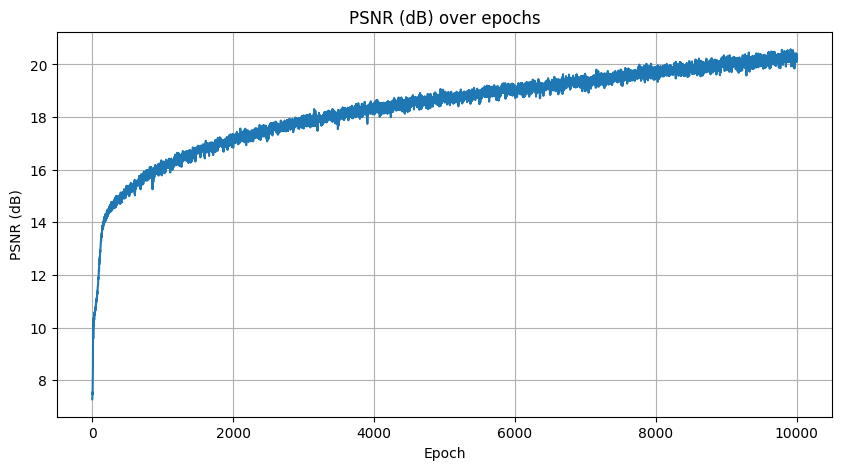

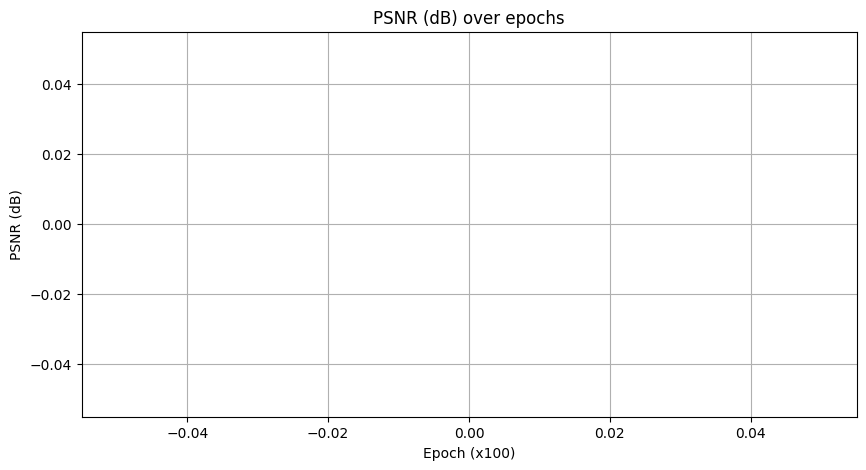

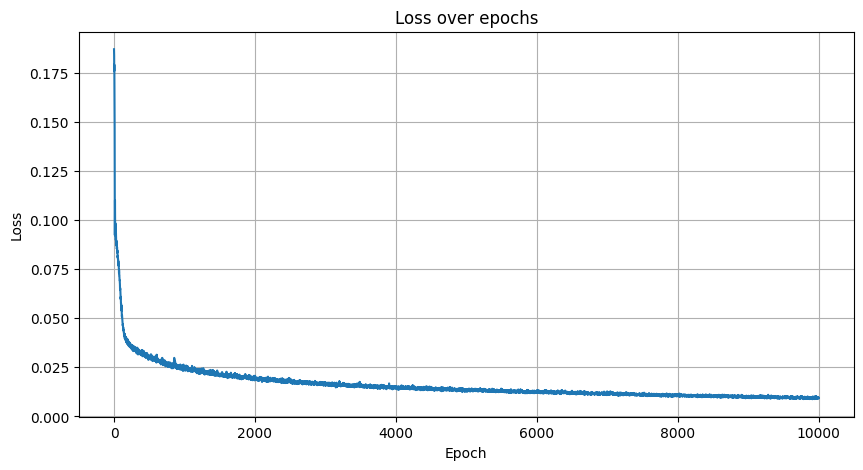

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 5e-4
weight_decay = 1e-5
batch_size = 10000
epochs = 10000
output_folder = "."
near = 0.02
far = 0.5
n_samples = 64

# Move validation images and c2ws to the device
images_val_t = torch.tensor(images_val, device=device, dtype=torch.float32)
c2ws_val_t = torch.tensor(c2ws_val, device=device, dtype=torch.float32)
c2ws_test_t = torch.tensor(c2ws_test, device=device, dtype=torch.float32)

# Create the model and move it to the GPU
model = NERF_3D().to(device)

# Load the dataset and move it onto the gpu
dataset = RaysData(images_train, K, c2ws_train, device=device)

# Create the loss function and the optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Pass the GPU data to the train_loop
train_loop(model, optimizer, loss_fn, device, epochs, batch_size, near, far, n_samples, images_val_t, c2ws_val_t, c2ws_test_t, output_folder)

In [12]:
# Generate a circling video of the custom object
custom_frames = generate_frames(c2ws_test_t, dataset, model, near, far, n_samples)
save_video(custom_frames, "./custom_circling_views.mp4")

In [ ]:
# Used to find good bounds for near and far
%pip install viser
import viser, time  # pip install viser
import numpy as np

# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train, numpy=True)
rays_o, rays_d, pixels = dataset.sample_rays(100) # Should expect (B, 3)
points = sample_along_rays(rays_o, rays_d, perturb=True, near=0.02, far=0.5, n_samples=32)
H, W = images_train.shape[1:3]
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
    server.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K[0, 0]),
        aspect=W / H,
        scale=0.01,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image
    )
for i, (o, d) in enumerate(zip(rays_o, rays_d)):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 0.25)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.002,
)

while True:
    time.sleep(0.1)  # Wait to allow visualization to run

╭────── viser (listening *:8082) ───────╮
│             ╷                         │
│   HTTP      │ http://localhost:8082   │
│   Websocket │ ws://localhost:8082     │
│             ╵                         │
╰───────────────────────────────────────╯

(viser) Share URL requested!

(viser) Generated share URL (expires in 24 hours, max 16 clients): https://predictive-separated.share.viser.studio

/tmp/ipython-input-618697060.py:14: DeprecationWarning: ViserServer.add_camera_frustum has been deprecated, use ViserServer.scene.add_camera_frustum instead. Alternatively, pin to `viser<0.2.0`.
  server.add_camera_frustum(
/tmp/ipython-input-618697060.py:24: DeprecationWarning: ViserServer.add_spline_catmull_rom has been deprecated, use ViserServer.scene.add_spline_catmull_rom instead. Alternatively, pin to `viser<0.2.0`.
  server.add_spline_catmull_rom(
/tmp/ipython-input-618697060.py:27: DeprecationWarning: ViserServer.add_point_cloud has been deprecated, use ViserServer.scene.add_point_cloud instead. Alternatively, pin to `viser<0.2.0`.
  server.add_point_cloud(


(viser) Connection opened (0, 1 total), 432 persistent messages

(viser) Connection closed (0, 0 total)

KeyboardInterrupt: 

(viser) Disconnected from share URL